In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from ts2vec import TS2Vec


In [4]:
torch.cuda.is_available()

True

In [ ]:
from utils import load_dataset

# Configurations

In [6]:
config = dict(
    batch_size=2,
    lr=0.001,
    output_dims=1024,
    max_train_length=5000
)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

# Useful functions

In [8]:
def get_train_test_data(data_files):
    train_files = []
    test_files = []

    train_labels = []
    test_labels = []

    for operator in data_files:
        train_files.extend(data_files[operator]['train_files'])
        train_labels.extend([data_files[operator]['label']]*len(data_files[operator]['train_files']))

        test_files.extend(data_files[operator]['test_files'])
        test_labels.extend([data_files[operator]['label']]*len(data_files[operator]['test_files']))

    # train_set, train_labels = load_files(train_files, train_labels)
    # test_set, test_labels = load_files(test_files, test_labels)

    return train_files, train_labels, test_files, test_labels

In [9]:
def evaluate(model, X_train, y_train, X_test, y_test, class_names, save_confusion_matrix=False, save_confusion_matrix_path=None, confusion_matrix_title='Confusion Matrix'):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print("Training Classification Report:")
    print(classification_report(y_train, train_preds, digits=4))
    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, digits=4))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    plt.figure()

    # Confusion Matrix
    print("Confusion Matrix (Test):")
    cm = confusion_matrix(y_test, test_preds)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap_ax = sns.heatmap(cm, annot=True, fmt='d', linewidth=.5 , cmap='crest',
                xticklabels=class_names, 
                yticklabels=class_names,
                annot_kws={"size": 20})

    # Increase colorbar (legend) font size
    cbar = heatmap_ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)

    plt.xlabel('Predicted', fontsize=24)
    plt.ylabel('True', fontsize=24)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.title(confusion_matrix_title)
    plt.tight_layout()
    if save_confusion_matrix and save_confusion_matrix_path:
        plt.savefig(save_confusion_matrix_path)

    plt.figure()
    # ROC Curve
    y_score = model.predict_proba(X_test)
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [11]:
import pandas as pd

def show_top_k(results, k=5, save=True, save_filename="results.csv"):
    # Number of top results to show
    k = 5  # change this as needed

    # Extract cv_results_ as DataFrame
    results_df = pd.DataFrame(results)

    # Save to CSV
    if save and save_filename is not None:
        results_df.to_csv(save_filename, index=False)

    # Choose the metric to sort by (e.g., mean_test_accuracy, mean_test_f1)
    sort_by = 'mean_test_accuracy'

    # Sort and select top-k
    top_k = results_df.sort_values(by=sort_by, ascending=False).head(k)

    # Columns to print: performance + params
    columns_to_show = [
        sort_by, 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'params'
    ]

    # Print nicely
    print(f"Top {k} models sorted by {sort_by}:")
    print(top_k[columns_to_show].to_string(index=False))


In [12]:
import joblib

def rf_grid_search(x_train, y_train, x_test, y_test, class_names, save_obj, save_filename):
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring=scoring, refit='f1')
    rf_grid.fit(x_train, y_train)
    print("Best params: ", rf_grid.best_params_)
    print (f'Train Accuracy - : {rf_grid.score(x_train, y_train):.3f}')
    print (f'Test Accuracy - : {rf_grid.score(x_train, y_train):.3f}')

    evaluate(rf_grid, x_train, y_train, x_test, y_test, class_names)
    joblib.dump(rf_grid, save_obj)
    show_top_k(rf_grid.cv_results_, save_filename=save_filename)

    return rf_grid

In [13]:
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def svr_grid_search(x_train, y_train, x_test, y_test, class_names, save_obj, save_filename):
    # Define pipeline: scaler + SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC())
    ])

    # Hyperparameter grid
    param_grid = {
        'svc__C': [0.1, 1],
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'svc__kernel': ['linear', 'rbf', 'poly']
    }

    # Grid search with pipeline
    svr_grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        refit='f1'
    )

    svr_grid.fit(x_train, y_train)
    print("Best params: ", svr_grid.best_params_)
    print (f'Train Accuracy - : {svr_grid.score(x_train, y_train):.3f}')
    print (f'Test Accuracy - : {svr_grid.score(x_train, y_train):.3f}')

    joblib.dump(svr_grid, save_obj)
    show_top_k(svr_grid.cv_results_, save_filename=save_filename)
    
    evaluate(svr_grid, x_train, y_train, x_test, y_test, class_names)

    return svr_grid

In [15]:
import joblib
from xgboost import XGBClassifier

def xgb_grid_search(x_train, y_train, x_test, y_test, class_names, save_obj, save_filename):
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [3, 6, 10],
        'gamma': [0, 1, 5]
    }

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)

    xgb_grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=scoring,  # or 'f1', 'roc_auc', etc.
        cv=5,
        n_jobs=-1,
        verbose=2,
        refit='f1'
    )

    xgb_grid.fit(x_train, y_train)
    print("Best params: ", xgb_grid.best_params_)
    print (f'Train Accuracy - : {xgb_grid.score(x_train, y_train):.3f}')
    print (f'Test Accuracy - : {xgb_grid.score(x_train, y_train):.3f}')

    evaluate(xgb_grid, x_train, y_train, x_test, y_test, class_names)
    joblib.dump(xgb_grid, save_obj)
    show_top_k(xgb_grid.cv_results_, save_filename=save_filename)

    return xgb_grid

# NEXMark TS2Vec

### Load model and embeddings

In [ ]:
model = TS2Vec(
    input_dims=1,
    device=device,
    **config
)

model.load(f'models/ts2vec_model_5000_1024.pkl')

train_embeddings = np.load("models/nexmark_train_embedding_5000_1024.npy")
test_embeddings = np.load("models/nexmark_test_embedding_5000_1024.npy")

### Load dataset

In [17]:
nexmark_dataset = load_dataset.load_nexmark_data(val_size=None)
nexmark_train_files, nexmark_train_labels, nexmark_test_files, nexmark_test_labels = get_train_test_data(nexmark_dataset)

### Random Forest

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6

Training Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       494
           1     1.0000    1.0000    1.0000       676
           2     1.0000    1.0000    1.0000       504
           3     1.0000    1.0000    1.0000       547
           4     1.0000    1.0000    1.0000       509
           5     1.0000    1.0000    1.0000       535
           6     1.0000    1.0000    1.0000       375

    accuracy                         1.0000      3640
   macro avg     1.0000    1.0000    1.0000      3640
weighted avg     1.0000    1.0000    1.0000      3640

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9218    0.5221    0.6667       768
           1     0.6126    0.9372    0.7409       621
           2     0.9843    0.9960    0.9902       505
           3     0.8476    0.8145    0.8307       512
           4     0.8703    0.8566    0.8634       509
           5     0

<Figure size 640x480 with 0 Axes>

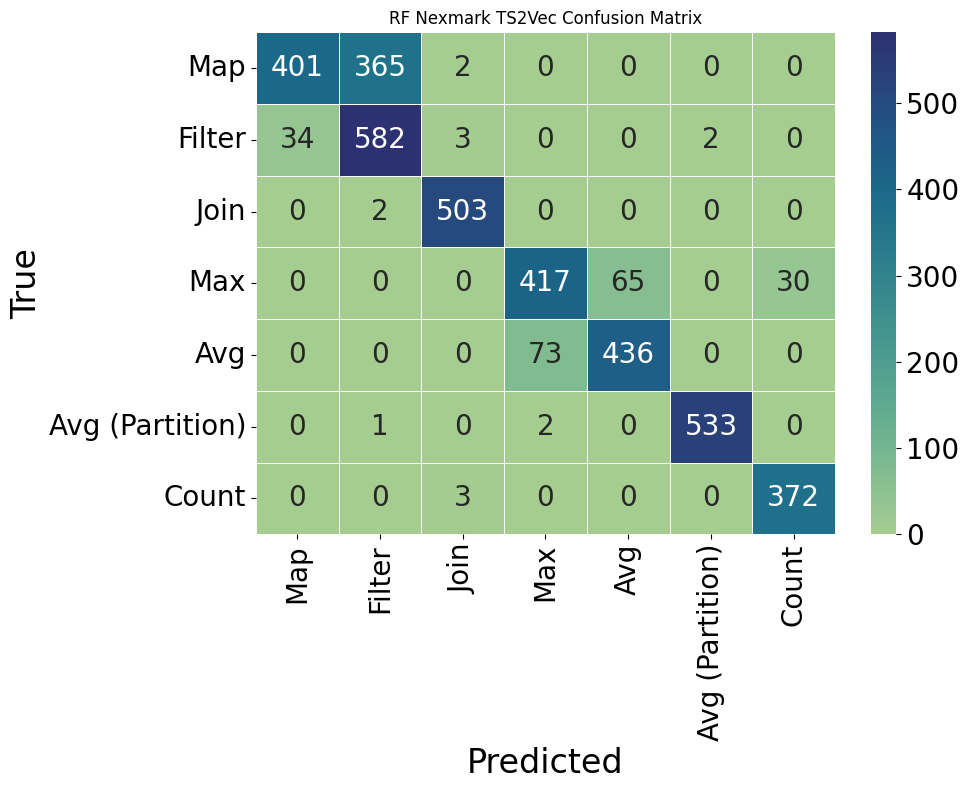

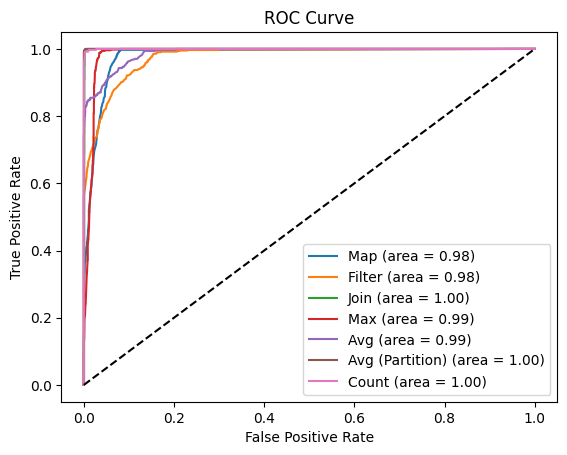

In [ ]:
rf_nexmark_ts2vec = joblib.load("models/rf_nexmark.pkl")
evaluate(rf_nexmark_ts2vec, train_embeddings, nexmark_train_labels, test_embeddings, nexmark_test_labels, load_dataset.NEXMARK_CLASS_NAMES, save_confusion_matrix=True, save_confusion_matrix_path="results/rf_nexmark_ts2vec_confusion_matrix.pdf", confusion_matrix_title='RF Nexmark TS2Vec Confusion Matrix')

### SVM

In [ ]:
svr_nexmark_ts2vec = joblib.load("models/svr_grid_nexmark.pkl")

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. Th

Training Classification Report:
              precision    recall  f1-score   support

           0     0.8592    0.9879    0.9190       494
           1     0.9883    0.8743    0.9278       676
           2     1.0000    1.0000    1.0000       504
           3     0.9415    1.0000    0.9699       547
           4     1.0000    0.9332    0.9654       509
           5     0.9907    0.9981    0.9944       535
           6     1.0000    1.0000    1.0000       375

    accuracy                         0.9654      3640
   macro avg     0.9685    0.9705    0.9681      3640
weighted avg     0.9686    0.9654    0.9654      3640

Test Classification Report:
              precision    recall  f1-score   support

           0     0.8414    0.6081    0.7060       768
           1     0.6282    0.8406    0.7190       621
           2     0.9744    0.9802    0.9773       505
           3     0.8842    0.9395    0.9110       512
           4     0.9488    0.8743    0.9100       509
           5     0

AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

<Figure size 640x480 with 0 Axes>

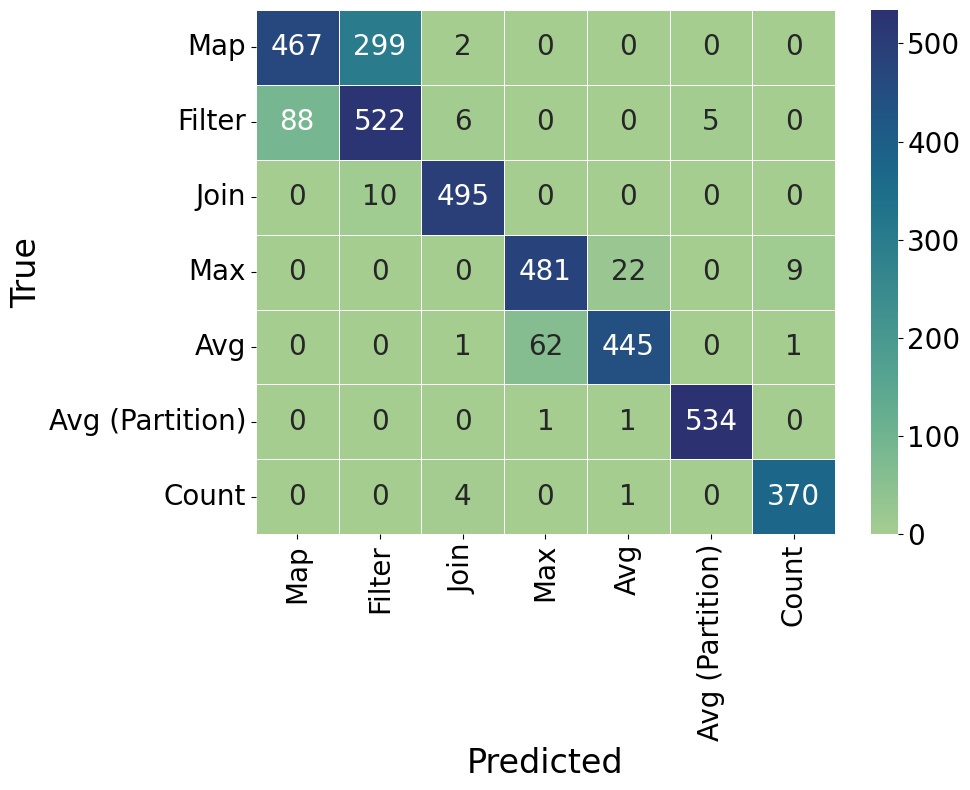

<Figure size 640x480 with 0 Axes>

In [ ]:
evaluate(
    svr_nexmark_ts2vec, 
    train_embeddings, 
    nexmark_train_labels, 
    test_embeddings, 
    nexmark_test_labels, 
    class_names=load_dataset.NEXMARK_CLASS_NAMES, 
    save_confusion_matrix=True, 
    save_confusion_matrix_path="results/svr_nexmark_ts2vec_confusion_matrix.pdf",
    confusion_matrix_title=''
)

### XGB

/home/bkcs/miniforge3/lib/python3.12/pickle.py:1760: UserWarning: [08:49:03] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       494
           1     1.0000    1.0000    1.0000       676
           2     1.0000    1.0000    1.0000       504
           3     1.0000    1.0000    1.0000       547
           4     1.0000    1.0000    1.0000       509
           5     1.0000    1.0000    1.0000       535
           6     1.0000    1.0000    1.0000       375

    accuracy                         1.0000      3640
   macro avg     1.0000    1.0000    1.0000      3640
weighted avg     1.0000    1.0000    1.0000      3640

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9398    0.4674    0.6243       768
           1     0.5910    0.9469    0.7277       621
           2     0.9767    0.9980    0.9873       505
           3     0.8731    0.8867    0.8798       512
           4     0.9325    0.8684    0.8993       509
           5     0

<Figure size 640x480 with 0 Axes>

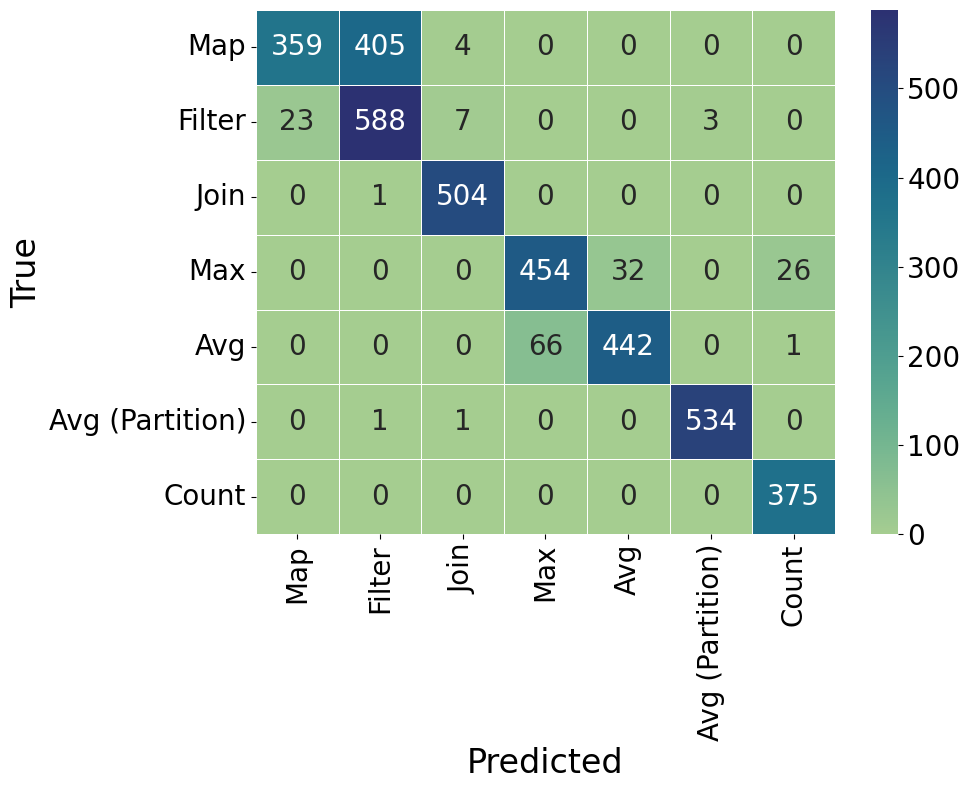

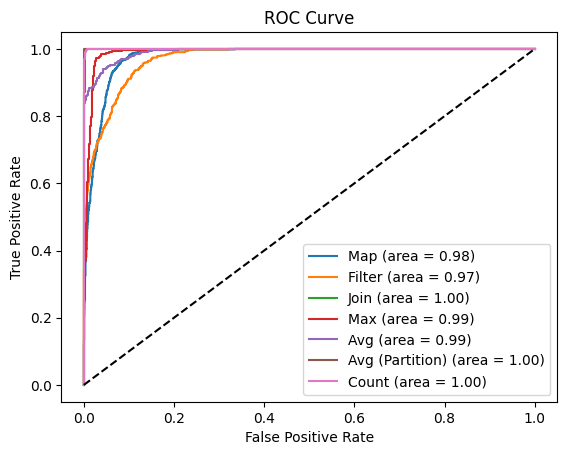

In [ ]:
xgb_nexmark_ts2vec = joblib.load("models/xgb_grid_nexmark.pkl")
evaluate(
    xgb_nexmark_ts2vec, 
    train_embeddings, 
    nexmark_train_labels, 
    test_embeddings, 
    nexmark_test_labels, 
    class_names=load_dataset.NEXMARK_CLASS_NAMES, 
    save_confusion_matrix=True, 
    save_confusion_matrix_path="results/xgb_nexmark_ts2vec_confusion_matrix.pdf",
    confusion_matrix_title=''
)

### Training RF, SVM, and XGB models

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_est

<Figure size 640x480 with 0 Axes>

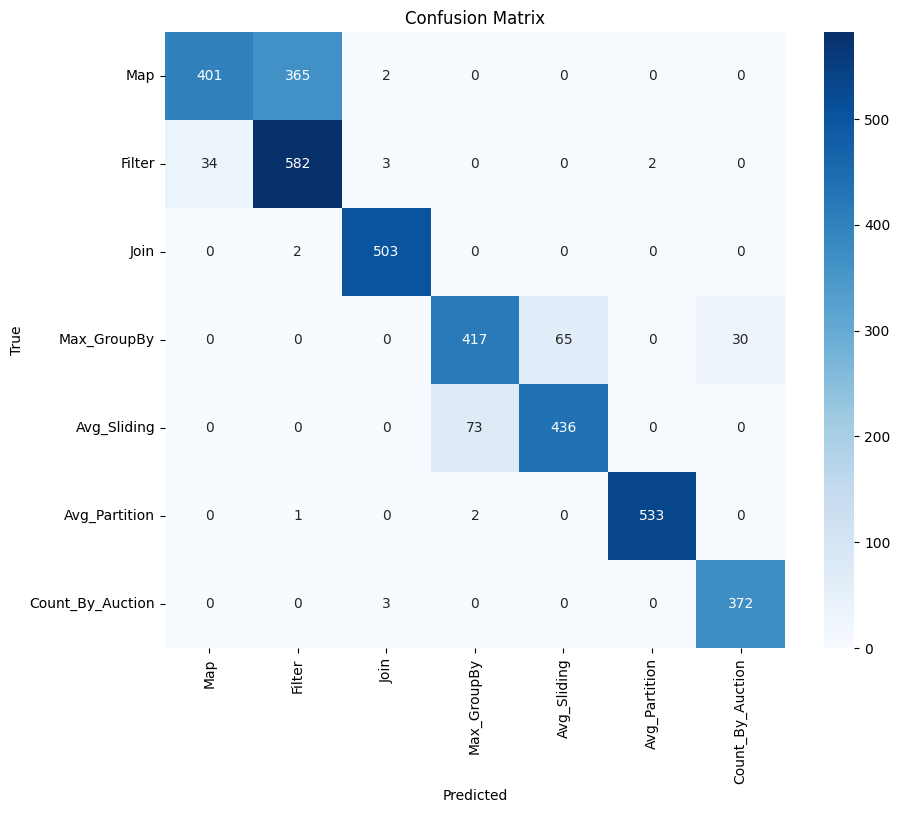

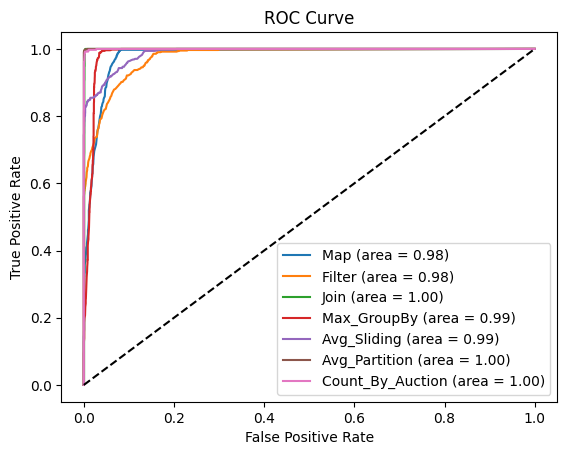

Top 5 models sorted by mean_test_accuracy:
 mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1                                                                               params
           0.942582             0.947641          0.942582      0.942418 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 250}
           0.942308             0.947443          0.942308      0.942145 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}
           0.942033             0.947297          0.942033      0.941855 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
           0.942033             0.947186          0.942033      0.941843 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
           0.942033             0.947006          0.942033      0.941843   {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


In [ ]:
rf_grid_nexmark = rf_grid_search(
    train_embeddings, 
    nexmark_train_labels, 
    test_embeddings, 
    nexmark_test_labels, 
    class_names=load_dataset.NEXMARK_CLASS_NAMES, 
    save_obj='models/rf_grid_nexmark.pkl', 
    save_filename='models/rf_grid_nexmark_results.csv'
)

In [ ]:
svr_grid_nexmark = svr_grid_search(
    train_embeddings, 
    nexmark_train_labels, 
    test_embeddings, 
    nexmark_test_labels, 
    class_names=load_dataset.NEXMARK_CLASS_NAMES, 
    save_obj='models/svr_grid_nexmark.pkl', 
    save_filename='models/svr_grid_nexmark_results.csv'
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=  17.8s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=  18.5s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=  18.7s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=  19.2s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=  19.3s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=  19.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=scale, svc__kernel=poly; total time=  27.2s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=scale, svc__kernel=poly; total time=  30.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=  31.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=  32.3s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=  15.1s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=  15.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=  35.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=scale, svc__kernel=poly; total time=  35.7s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=  18.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=scale, svc__kernel=poly; total time=  36.8s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=  18.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=  38.3s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=  38.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=scale, svc__kernel=poly; total time=  39.1s
[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=  14.9s
[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=  18.7s
[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=  19.4s
[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=  17.9s
[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=  19.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=  37.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=  27.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=  38.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=  26.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=  33.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=  30.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=  28.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=  30.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=  35.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=  37.5s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=  12.4s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=  16.8s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=  21.0s
[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=  38.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=  18.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=0.001, svc__kernel=poly; total time=  23.1s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=  19.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=  30.2s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=  15.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=  35.0s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=0.001, svc__kernel=poly; total time=  32.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf; total time=  37.0s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=0.001, svc__kernel=poly; total time=  38.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=0.1, svc__gamma=0.001, svc__kernel=poly; total time=  39.2s
[CV] END .....svc__C=0.1, svc__gamma=0.001, svc__kernel=poly; total time=  38.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=  22.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=  25.1s
[CV] END .....svc__C=0.1, svc__gamma=0.1, svc__kernel=linear; total time=  16.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=  35.6s
[CV] END .....svc__C=0.1, svc__gamma=0.1, svc__kernel=linear; total time=  13.7s
[CV] END .....svc__C=0.1, svc__gamma=0.1, svc__kernel=linear; total time=  19.5s
[CV] END ......svc__C=0.1, svc__gamma=0.01, svc__kernel=poly; total time=  28.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.01, svc__kernel=poly; total time=  25.7s
[CV] END .....svc__C=0.1, svc__gamma=0.1, svc__kernel=linear; total time=  20.0s
[CV] END .....svc__C=0.1, svc__gamma=0.1, svc__kernel=linear; total time=  17.2s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=  36.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf; total time=  38.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.01, svc__kernel=poly; total time=  35.3s
[CV] END .......svc__C=0.1, svc__gamma=0.1, svc__kernel=poly; total time=   8.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.01, svc__kernel=poly; total time=  34.5s
[CV] END .......svc__C=0.1, svc__gamma=0.1, svc__kernel=poly; total time=   5.8s
[CV] END .......svc__C=0.1, svc__gamma=0.1, svc__kernel=poly; total time=   8.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=0.1, svc__gamma=0.01, svc__kernel=poly; total time=  36.2s
[CV] END .......svc__C=0.1, svc__gamma=0.1, svc__kernel=poly; total time=   9.8s
[CV] END .......svc__C=0.1, svc__gamma=0.1, svc__kernel=poly; total time=   8.8s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   9.2s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   4.9s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  14.3s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  12.5s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=  32.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  15.6s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   4.6s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   4.4s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   2.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=  32.2s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   5.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  17.3s
[CV] END .....svc__C=1, svc__gamma=scale, svc__kernel=linear; total time=   6.0s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=  19.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=  27.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=  34.0s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=  16.5s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=  19.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=  31.5s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=  20.2s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=  20.1s
[CV] END .....svc__C=1, svc__gamma=scale, svc__kernel=linear; total time=  10.8s
[CV] END .....svc__C=1, svc__gamma=scale, svc__kernel=linear; total time=   9.8s
[CV] END .....svc__C=1, svc__gamma=scale, svc__kernel=linear; total time=   9.9s
[CV] END .....svc__C=1, svc__gamma=scale, svc__kernel=linear; total time=  11.3s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=   8.6s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=   9.6s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=   8.9s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=  10.7s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=  10.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=  23.2s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=  27.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=  32.0s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=  34.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=  31.4s
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=  35.2s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=  31.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=  34.6s
[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=  33.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=  35.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=  24.1s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   9.0s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   8.9s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   9.7s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=  11.1s
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=  29.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=  10.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=  38.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=  33.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=  25.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=  35.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=  36.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=  26.5s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   9.4s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   8.4s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=  10.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=  24.4s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   7.0s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=  37.1s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   8.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=  36.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=  27.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=  35.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=  29.6s
[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=  28.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=  27.9s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=  33.2s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=  31.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=  35.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=  35.5s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=  10.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=  22.9s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   7.9s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   9.8s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=  10.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.01, svc__kernel=poly; total time=  21.2s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=  10.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=  30.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=  30.0s
[CV] END .........svc__C=1, svc__gamma=0.1, svc__kernel=poly; total time=   5.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=  28.2s
[CV] END .........svc__C=1, svc__gamma=0.1, svc__kernel=poly; total time=   4.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.01, svc__kernel=poly; total time=  27.4s
[CV] END .........svc__C=1, svc__gamma=0.1, svc__kernel=poly; total time=   4.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=  29.8s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=  12.1s
[CV] END ........svc__C=1, svc__gamma=0.01, svc__kernel=poly; total time=  23.9s
[CV] END .........svc__C=1, svc__gamma=0.1, svc__kernel=poly; total time=   5.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=0.1, svc__kernel=poly; total time=   5.6s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=  17.1s
[CV] END ........svc__C=1, svc__gamma=0.01, svc__kernel=poly; total time=  25.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .........svc__C=1, svc__gamma=1, svc__kernel=linear; total time=   5.7s
[CV] END .........svc__C=1, svc__gamma=1, svc__kernel=linear; total time=   6.8s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   2.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=0.01, svc__kernel=poly; total time=  28.7s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   4.8s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   2.4s[CV] END .........svc__C=1, svc__gamma=1, svc__kernel=linear; total time=  11.0s

[CV] END .........svc__C=1, svc__gamma=1, svc__kernel=linear; total time=   8.9s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=  19.4s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=  17.7s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   5.0s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=  19.9s
[CV] END .........svc__C=1, svc__gamma=1, svc__kernel=linear; total time=   8.7s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   4.1s
[CV] END ....svc__C=10, svc__gamma=scale, svc__kernel=linear; total time=   4.9s
[CV] END ....svc__C=10, svc_

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=  23.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=  24.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=  21.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=  26.3s
[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=  27.2s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=  28.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=  31.1s
[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   6.0s
[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   4.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=  30.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=  24.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=  27.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=  32.3s
[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=  32.8s
[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   5.9s
[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   3.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=  27.0s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=  26.6s
[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   5.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=  27.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=  28.2s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   6.4s
[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=  20.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   6.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=  23.6s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   6.0s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   5.9s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   6.3s
[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=  28.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=  17.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=  31.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=  21.5s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=   9.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=  25.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=  29.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=  29.0s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=  13.0s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=  15.9s
[CV] END .......svc__C=10, svc__gamma=0.01, svc__kernel=poly; total time=  10.8s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=  13.7s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=  29.3s
[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=  30.6s
[CV] END .......svc__C=10, svc__gamma=0.01, svc__kernel=poly; total time=  15.3s
[CV] END ........svc__C=10, svc__gamma=0.01, svc__kernel=rbf; total time=  17.5s
[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   4.0s
[CV] END .......svc__C=10, svc__gamma=0.01, svc__kernel=poly; total time=  15.8s
[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   7.4s
[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=  32.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   5.7s
[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   6.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=  35.3s
[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   6.5s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=  36.3s
[CV] END .........svc__C=10, svc__gamma=0.1, svc__kernel=rbf; total time=   7.7s
[CV] END ........svc__C=10, svc__gamma=0.1, svc__kernel=poly; total time=   5.3s
[CV] END ........svc__C=10, svc__gamma=0.1, svc__kernel=poly; total time=   5.6s
[CV] END ........svc__C=10, svc__gamma=0.1, svc__kernel=poly; total time=   4.6s
[CV] END ........svc__C=10, svc__gamma=0.1, svc__kernel=poly; total time=   5.4s
[CV] END .........svc__C=10, svc__gamma=0.1, svc__kernel=rbf; total time=   8.9s
[CV] END ........svc__C=10, svc__gamma=0.1, svc__kernel=poly; total time=   5.6s
[CV] END .........svc__C=10, svc__gamma=0.1, svc__kernel=rbf; total time=  10.5s
[CV] END ........svc__C=10, svc__gamma=1, svc__kernel=linear; total time=   2.1s
[CV] END .......svc__C=10, svc__gamma=0.01, svc__kernel=poly; total time=  15.6s
[CV] END ........svc__C=10, svc__gamma=1, svc__kernel=linear; total time=   6.0s
[CV] END .......svc__C=10, s

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=100, svc__gamma=auto, svc__kernel=poly; total time=  16.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=  26.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=  28.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=  29.4s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=100, svc__gamma=auto, svc__kernel=poly; total time=  21.1s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   1.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=  33.6s
[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=  10.3s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=  33.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=100, svc__gamma=auto, svc__kernel=poly; total time=  24.4s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   4.3s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   2.9s
[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=  15.9s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   4.7s
[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=  13.4s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   4.9s
[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=  15.6s
[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=  16.1s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=100, svc__gamma=auto, svc__kernel=poly; total time=  33.8s
[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=   6.7s
[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=   8.8s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=100, svc__gamma=auto, svc__kernel=poly; total time=  34.5s
[CV] END ......svc__C=100, svc__gamma=0.01, svc__kernel=poly; total time=   7.6s
[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=  10.0s
[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=   8.5s
[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=   9.5s
[CV] END .....svc__C=100, svc__gamma=0.1, svc__kernel=linear; total time=   3.8s
[CV] END ......svc__C=100, svc__gamma=0.01, svc__kernel=poly; total time=   9.2s
[CV] END .....svc__C=100, svc__gamma=0.1, svc__kernel=linear; total time=   5.1s
[CV] END ......svc__C=100, svc__gamma=0.01, svc__kernel=poly; total time=   9.3s
[CV] END ......svc__C=100, svc__gamma=0.01, svc__kernel=poly; total time=   8.3s
[CV] END .....svc__C=100, svc__gamma=0.1, svc__kernel=linear; total time=   4.6s
[CV] END ......svc__C=100, svc__gamma=0.01, svc__kernel=poly; total time=   8.2s
[CV] END .....svc__C=100, sv

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=  25.1s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=   7.7s
[CV] END .......svc__C=100, svc__gamma=0.1, svc__kernel=poly; total time=   4.6s
[CV] END .......svc__C=100, svc__gamma=0.1, svc__kernel=poly; total time=   4.7s
[CV] END .......svc__C=100, svc__gamma=1, svc__kernel=linear; total time=   2.3s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=   8.6s
[CV] END .......svc__C=100, svc__gamma=0.1, svc__kernel=poly; total time=   4.9s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=  28.6s
[CV] END .......svc__C=100, svc__gamma=1, svc__kernel=linear; total time=   5.1s
[CV] END .......svc__C=100, svc__gamma=1, svc__kernel=linear; total time=   5.2s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=   9.3s
[CV] END .......svc__C=100, svc__gamma=1, svc__kernel=linear; total time=   2.4s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=  10.1s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=  10.0s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=  32.3s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   3.1s
[CV] END .......svc__C=100, svc__gamma=1, svc__kernel=linear; total time=   4.4s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   2.5s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   3.8s
[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=  33.4s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   3.6s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   3.6s
[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=  34.6s


/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   4.9s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   5.2s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   4.9s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   5.6s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   5.4s
Best params:  {'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Train Accuracy - : 0.965
Test Accuracy - : 0.965
Top 5 models sorted by mean_test_accuracy:
 mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1                                                        params
           0.940659             0.946069          0.940659      0.940507        {'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
           0.929121             0.939033          0.929121      0.928887      {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}
           0.927747          

AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=  45.0s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=  48.2s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=  48.9s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=  49.9s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=  53.0s
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time= 1.1min
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time= 1.1min
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time= 1.1min
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time= 1.1min
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time= 1.1min
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time= 1.4min
[CV] END .............gamma=0, max_depth=3, n_e

<Figure size 640x480 with 0 Axes>

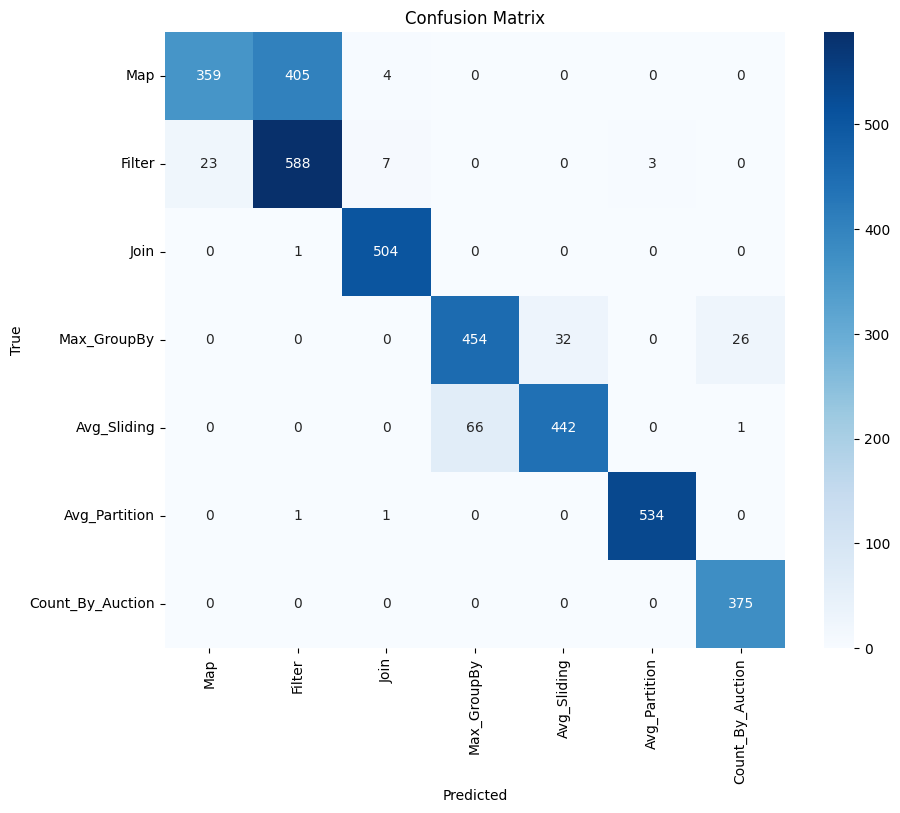

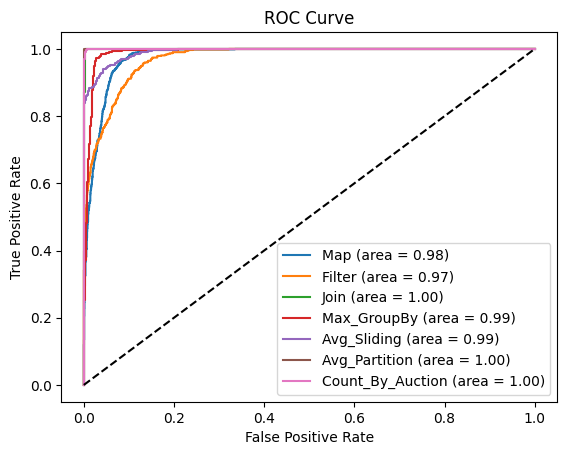

Top 5 models sorted by mean_test_accuracy:
 mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1                                            params
           0.948626             0.952149          0.948626      0.948466 {'gamma': 0, 'max_depth': 3, 'n_estimators': 150}
           0.948626             0.952202          0.948626      0.948461 {'gamma': 0, 'max_depth': 3, 'n_estimators': 200}
           0.947527             0.951291          0.947527      0.947397 {'gamma': 0, 'max_depth': 3, 'n_estimators': 100}
           0.947527             0.951021          0.947527      0.947373 {'gamma': 0, 'max_depth': 3, 'n_estimators': 250}
           0.947253             0.950750          0.947253      0.947096 {'gamma': 0, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
xgb_grid_nexmark = xgb_grid_search(
    train_embeddings, 
    nexmark_train_labels, 
    test_embeddings, 
    nexmark_test_labels, 
    class_names=load_dataset.NEXMARK_CLASS_NAMES, 
    save_obj='models/xgb_grid_nexmark.pkl', 
    save_filename='models/xgb_grid_nexmark_results.csv'
)

# Secure SGX TS2Vec

### Load dataset

In [22]:
secure_sgx_dataset = load_dataset.load_secure_sgx_data(train_size=0.5)
secure_sgx_train_files, secure_sgx_train_labels, secure_sgx_test_files, secure_sgx_test_labels = get_train_test_data(secure_sgx_dataset)

### Load embeddings

In [ ]:
secure_sgx_train_embeddings = np.load("models/secure_sgx_train_embedding_5000_1024.npy")
secure_sgx_test_embeddings = np.load("models/secure_sgx_test_embedding_5000_1024.npy")

### XGB

In [ ]:
xgb_secure_sgx_ts2vec = joblib.load("models/xgb_grid_secure_sgx.pkl")

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       190
           1     1.0000    1.0000    1.0000       176
           2     1.0000    1.0000    1.0000       241

    accuracy                         1.0000       607
   macro avg     1.0000    1.0000    1.0000       607
weighted avg     1.0000    1.0000    1.0000       607

Test Classification Report:
              precision    recall  f1-score   support

           0     0.8122    0.9789    0.8878       190
           1     0.9638    0.7557    0.8471       176
           2     1.0000    0.9959    0.9979       242

    accuracy                         0.9211       608
   macro avg     0.9253    0.9102    0.9110       608
weighted avg     0.9308    0.9211    0.9199       608

Confusion Matrix (Test):
[[186   4   0]
 [ 43 133   0]
 [  0   1 241]]
Confusion Matrix (Test):
[[186   4   0]
 [ 43 133   0]
 [  0   1 241]]


<Figure size 640x480 with 0 Axes>

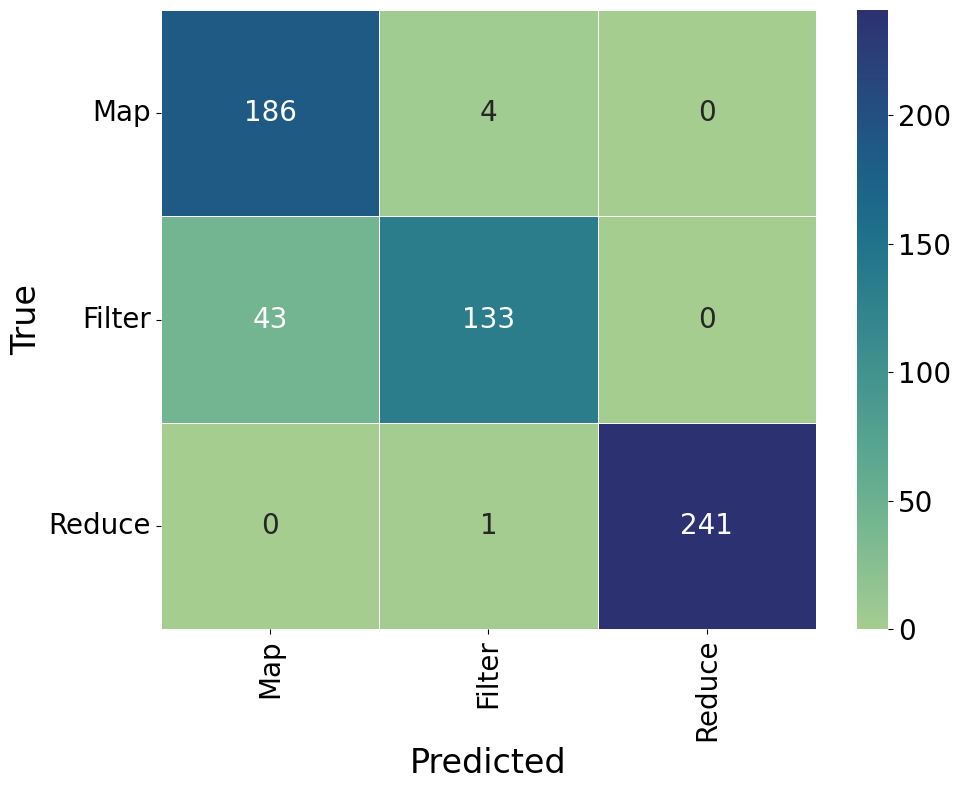

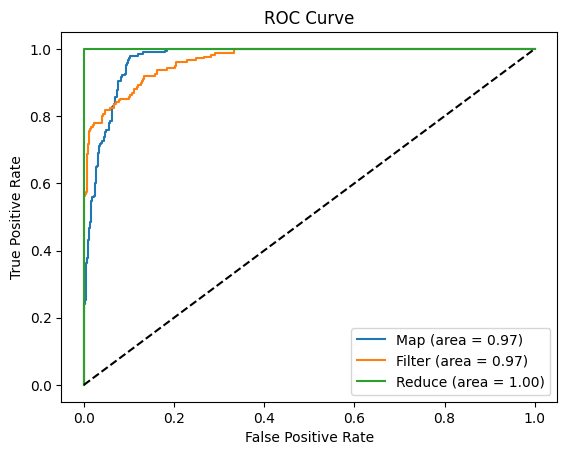

In [ ]:
evaluate(
    xgb_secure_sgx_ts2vec, 
    secure_sgx_train_embeddings, 
    secure_sgx_train_labels, 
    secure_sgx_test_embeddings, 
    secure_sgx_test_labels, 
    class_names=load_dataset.SECURE_SGX_CLASS_NAMES, 
    save_confusion_matrix=True, 
    save_confusion_matrix_path="results/xgb_secure_sgx_ts2vec_confusion_matrix.pdf", 
    confusion_matrix_title='')

### Random Forest

Training Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       190
           1     1.0000    1.0000    1.0000       176
           2     1.0000    1.0000    1.0000       241

    accuracy                         1.0000       607
   macro avg     1.0000    1.0000    1.0000       607
weighted avg     1.0000    1.0000    1.0000       607

Test Classification Report:
              precision    recall  f1-score   support

           0     0.7490    0.9895    0.8526       190
           1     0.9741    0.6420    0.7740       176
           2     1.0000    0.9959    0.9979       242

    accuracy                         0.8914       608
   macro avg     0.9077    0.8758    0.8748       608
weighted avg     0.9141    0.8914    0.8877       608

Confusion Matrix (Test):
[[188   2   0]
 [ 63 113   0]
 [  0   1 241]]
Confusion Matrix (Test):
[[188   2   0]
 [ 63 113   0]
 [  0   1 241]]


/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6

<Figure size 640x480 with 0 Axes>

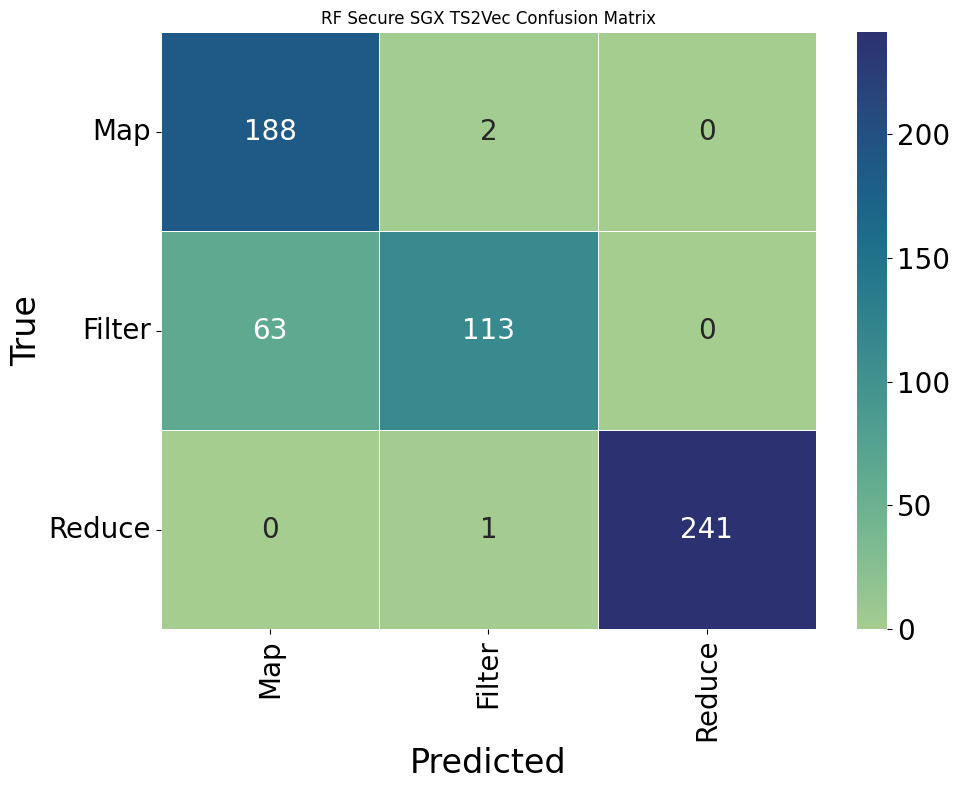

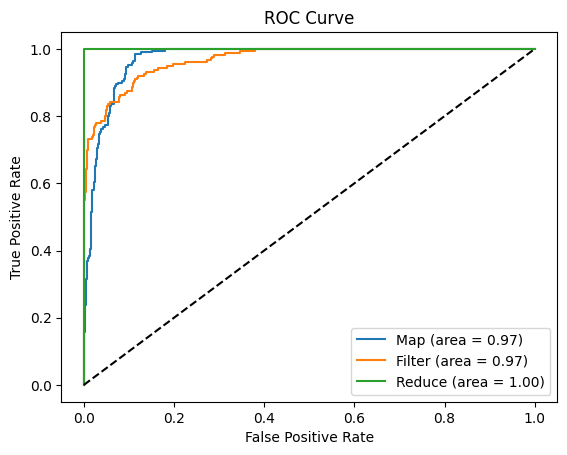

In [ ]:
rf_secure_sgx_ts2vec = joblib.load("models/rf_grid_secure_sgx.pkl")
evaluate(
    rf_secure_sgx_ts2vec, 
    secure_sgx_train_embeddings, 
    secure_sgx_train_labels, 
    secure_sgx_test_embeddings, 
    secure_sgx_test_labels, 
    class_names=load_dataset.SECURE_SGX_CLASS_NAMES,
    save_confusion_matrix=True,
    save_confusion_matrix_path="results/rf_secure_sgx_ts2vec_confusion_matrix.pdf",
    confusion_matrix_title='RF Secure SGX TS2Vec Confusion Matrix'
)

### SVM

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. Th

Training Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       190
           1     1.0000    1.0000    1.0000       176
           2     1.0000    1.0000    1.0000       241

    accuracy                         1.0000       607
   macro avg     1.0000    1.0000    1.0000       607
weighted avg     1.0000    1.0000    1.0000       607

Test Classification Report:
              precision    recall  f1-score   support

           0     0.8382    0.9000    0.8680       190
           1     0.8834    0.8182    0.8496       176
           2     1.0000    0.9959    0.9979       242

    accuracy                         0.9145       608
   macro avg     0.9072    0.9047    0.9052       608
weighted avg     0.9157    0.9145    0.9144       608

Confusion Matrix (Test):
[[171  19   0]
 [ 32 144   0]
 [  1   0 241]]
Confusion Matrix (Test):
[[171  19   0]
 [ 32 144   0]
 [  1   0 241]]


AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

<Figure size 640x480 with 0 Axes>

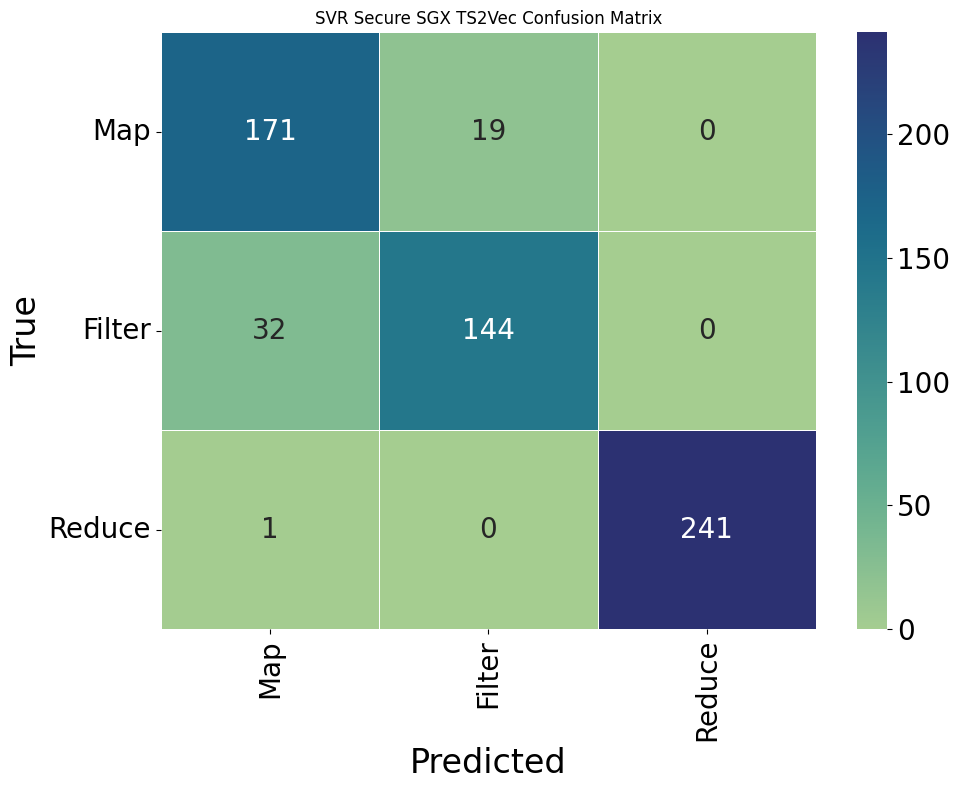

<Figure size 640x480 with 0 Axes>

In [ ]:
svr_secure_sgx_ts2vec = joblib.load("models/svr_grid_secure_sgx.pkl")
evaluate(
    svr_secure_sgx_ts2vec, 
    secure_sgx_train_embeddings, 
    secure_sgx_train_labels, 
    secure_sgx_test_embeddings, 
    secure_sgx_test_labels, 
    class_names=load_dataset.SECURE_SGX_CLASS_NAMES,
    save_confusion_matrix=True,
    save_confusion_matrix_path="results/svr_secure_sgx_ts2vec_confusion_matrix.pdf",
    confusion_matrix_title='SVR Secure SGX TS2Vec Confusion Matrix'
)

### Training RF, SVM, and XGB models

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=150; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_est

<Figure size 640x480 with 0 Axes>

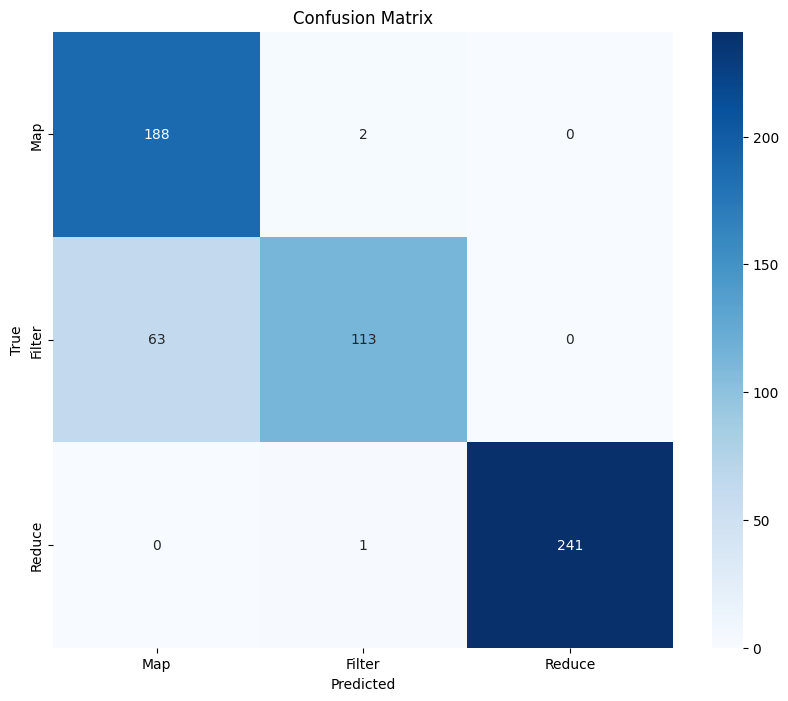

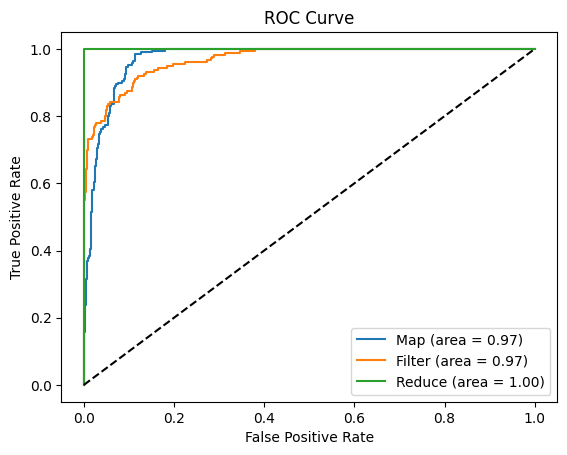

Top 5 models sorted by mean_test_accuracy:
 mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1                                                                               params
           0.901179             0.918182          0.901179      0.898239   {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 250}
           0.901179             0.918182          0.901179      0.898239 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 250}
           0.901179             0.917301          0.901179      0.898350 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
           0.901179             0.917301          0.901179      0.898350   {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
           0.901165             0.917713          0.901165      0.898392   {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


In [ ]:
rf_grid_secure_sgx = rf_grid_search(
    secure_sgx_train_embeddings, 
    secure_sgx_train_labels, 
    secure_sgx_test_embeddings, 
    secure_sgx_test_labels,    
    class_names=load_dataset.SECURE_SGX_CLASS_NAMES,
    save_obj='models/rf_grid_secure_sgx.pkl',
    save_filename='models/rf_grid_secure_sgx_results.csv'
)

In [ ]:
svr_grid_secure_sgx = svr_grid_search(
    secure_sgx_train_embeddings, 
    secure_sgx_train_labels, 
    secure_sgx_test_embeddings, 
    secure_sgx_test_labels,    
    class_names=load_dataset.SECURE_SGX_CLASS_NAMES,
    save_obj='models/svr_grid_secure_sgx.pkl',
    save_filename='models/svr_grid_secure_sgx_results.csv'
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=0.1, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.2s
[CV] END ....svc__C=0.1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=scale, svc__kernel=rbf; total time=   0.2s
[CV] END ......svc__C=0.1, svc__gamma=scale, sv

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=   0.2s
[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=   0.2s
[CV] END ...svc__C=0.1, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=   0.2s
[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=   0.3s
[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=0.1, svc__gamma=auto, svc__kernel=rbf; total time=   0.4s[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=   0.3s[CV] END ......svc__C=0.1, svc__gamma=auto, svc__kernel=poly; total time=   0.3s


[CV] END ....svc__C=0.1, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=0.1, svc__gamma=0.01, svc__kernel=poly; total time=   0.1s
[CV] END ......svc__C=0.1, s

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=0.1, svc__gamma=0.1, svc__kernel=poly; total time=   0.1s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.2s

[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=   0.1s
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=   0.2s
[CV] END ......svc__C=1, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=1, sv

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.2s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.3s
[CV] END ........svc__C=1, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=   0.2s
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=   0.2s

[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=scale, svc__kernel=poly; total time=   0.1s
[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=   0.1s
[CV] END .....svc__C=1, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END .....svc__C=1, svc_

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=   0.2s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=   0.2s
[CV] END ........svc__C=1, svc__gamma=auto, svc__kernel=poly; total time=   0.2s
[CV] END ........svc__C=1, svc__gamma=0.001, svc__kernel=rbf; total time=   0.3s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END .........svc__C=0.1, svc__gamma=1, svc__kernel=poly; total time=   0.1s[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s

[CV] END ........svc__C=1, svc__gamma=0.01, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   0.1s
[CV] END ........svc__C=1, s

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END ....svc__C=10, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END .........svc__C=1, svc__gamma=0.1, svc__kernel=poly; total time=   0.2s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=10, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=   0.1s
[CV] END ...........svc__C=1, svc__gamma=1, svc__kernel=poly; total time=   0.2s
[CV] END .......svc__C=10, svc__gamma=scale, svc__kernel=rbf; total time=   0.2s
[CV] END ..........svc__C=1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.4s
[CV] END .....svc__C=10, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=10, s

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END ............svc__C=1, svc__gamma=1, svc__kernel=rbf; total time=   0.4s
[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=   0.1s
[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s
[CV] END .........svc__C=1, svc__gamma=0.01, svc__kernel=rbf; total time=   0.3s
[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=auto, svc__kernel=poly; total time=   0.1s
[CV] END ........svc__C=10, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s[CV] END .....svc__C=10, svc__gamma=auto, svc__kernel=linear; total time=   0.1s

[CV] END ....svc__C=10, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END .....svc__C=10, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=10, svc__gamma=scale, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=10, s

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=   0.2s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=   0.2s
[CV] END ......svc__C=10, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=0.01, svc__kernel=poly; total time=   0.1s
[CV] END ............svc__C=1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=10, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END .....svc__C=10, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=10, svc__gamma=0.1, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=10, sv

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END ........svc__C=10, svc__gamma=1, svc__kernel=linear; total time=   0.1s
[CV] END .........svc__C=10, svc__gamma=0.1, svc__kernel=rbf; total time=   0.3s
[CV] END ...........svc__C=10, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ..........svc__C=10, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=   0.1s
[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ...svc__C=100, svc__gamma=scale, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=100, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END .....svc__C=100, svc__gamma=scale, svc__kernel=poly; total time=   0.1s
[CV] END ...........svc__C=10, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END .........svc__C=10,

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END ......svc__C=100, svc__gamma=scale, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=100, svc__gamma=auto, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=100, svc__gamma=auto, svc__kernel=rbf; total time=   0.2s
[CV] END .......svc__C=100, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s
[CV] END ...svc__C=100, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END ...svc__C=100, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END ..........svc__C=10, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END ...svc__C=100, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END .......svc__C=100, svc__gamma=auto, svc__kernel=rbf; total time=   0.2s
[CV] END ......svc__C=100, svc__gamma=auto, svc__kernel=poly; total time=   0.1s
[CV] END .........svc__C=10, svc__gamma=0.1, svc__kernel=rbf; total time=   0.3s
[CV] END ...svc__C=100, svc__gamma=0.001, svc__kernel=linear; total time=   0.1s
[CV] END ...........svc__C=1

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=   0.2s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s[CV] END ...........svc__C=10, svc__gamma=1, svc__kernel=rbf; total time=   0.3s

[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END .......svc__C=100, svc__gamma=auto, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END ......svc__C=100, svc__gamma=0.001, svc__kernel=rbf; total time=   0.1s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END ....svc__C=100, svc__gamma=0.01, svc__kernel=linear; total time=   0.1s
[CV] END .....svc__C=100, svc__gamma=0.001, svc__kernel=poly; total time=   0.1s
[CV] END .....svc__C=100, svc__gamma=0.1, svc__kernel=linear; total time=   0.1s
[CV] END .....svc__C=100, sv

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=   0.5s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END .........svc__C=100, svc__gamma=1, svc__kernel=poly; total time=   0.1s
[CV] END ......svc__C=100, svc__gamma=0.01, svc__kernel=poly; total time=   0.1s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   0.2s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   0.2s
[CV] END .......svc__C=100, svc__gamma=0.01, svc__kernel=rbf; total time=   0.1s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END ........svc__C=100, svc__gamma=0.1, svc__kernel=rbf; total time=   0.1s
[CV] END ..........svc__C=100, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ..........svc__C=10

/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/miniforge3/envs/hungpm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Best params:  {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Train Accuracy - : 1.000
Test Accuracy - : 1.000
Top 5 models sorted by mean_test_accuracy:
 mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1                                                         params
            0.91596             0.916731           0.91596      0.915832    {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
            0.91596             0.916731           0.91596      0.915832     {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
            0.91596             0.916731           0.91596      0.915832      {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
            0.91596             0.916731           0.91596      0.915832        {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': 'linear'}
            0.91596             0.916731           0.91596      0.915832 {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Training Classif

AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   7.6s
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time=   8.6s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   8.8s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   9.1s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   9.9s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=  10.0s
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time=  10.3s
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time=  10.7s
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time=  11.0s
[CV] END .............gamma=0, max_depth=3, n_estimators=150; total time=  11.3s
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time=  11.9s
[CV] END .............gamma=0, max_depth=3, n_e

<Figure size 640x480 with 0 Axes>

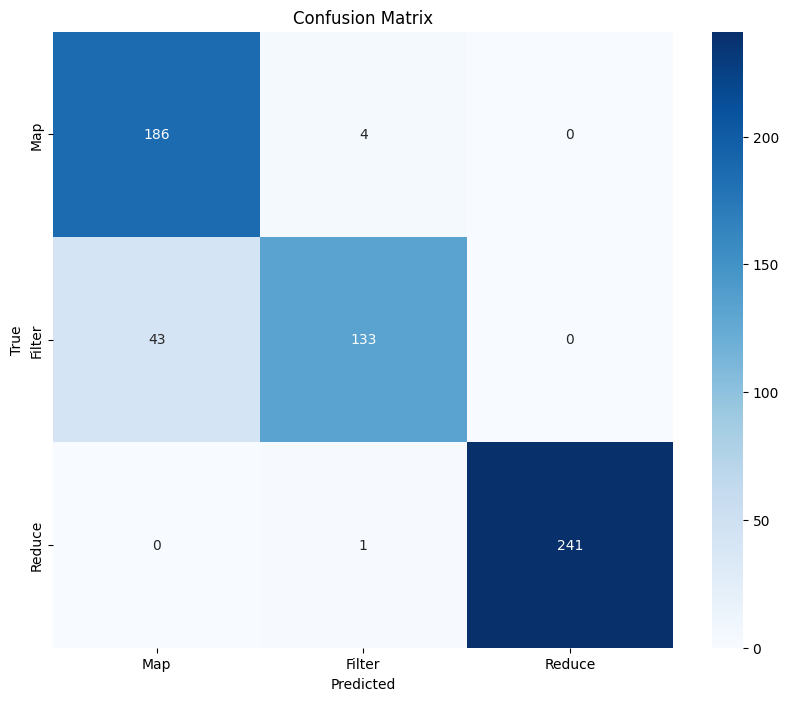

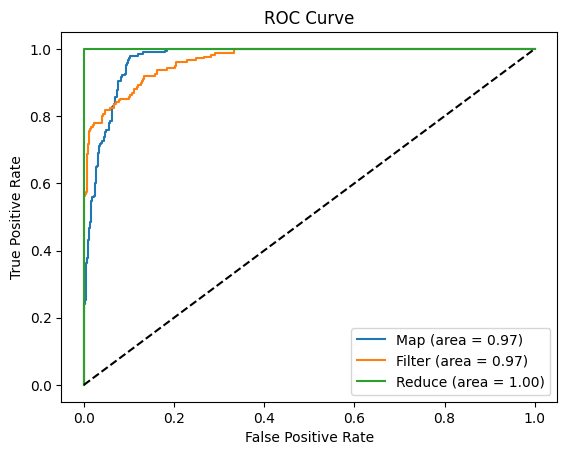

Top 5 models sorted by mean_test_accuracy:
 mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1                                             params
           0.915973             0.921809          0.915973      0.915105 {'gamma': 0, 'max_depth': 10, 'n_estimators': 150}
           0.915973             0.921809          0.915973      0.915105 {'gamma': 0, 'max_depth': 10, 'n_estimators': 200}
           0.915973             0.921809          0.915973      0.915105 {'gamma': 0, 'max_depth': 10, 'n_estimators': 250}
           0.915973             0.921809          0.915973      0.915105 {'gamma': 0, 'max_depth': 10, 'n_estimators': 300}
           0.912681             0.921793          0.912681      0.911401  {'gamma': 0, 'max_depth': 3, 'n_estimators': 200}


In [ ]:
xgb_grid_secure_sgx = xgb_grid_search(
    secure_sgx_train_embeddings, 
    secure_sgx_train_labels, 
    secure_sgx_test_embeddings, 
    secure_sgx_test_labels,    
    class_names=load_dataset.SECURE_SGX_CLASS_NAMES,
    save_obj='models/xgb_grid_secure_sgx.pkl',
    save_filename='models/xgb_grid_secure_sgx_results.csv'
)